In [1]:
import numpy as np
import pandas as pd
import os
# import yaml
import torch
import random
from datetime import datetime

import geopandas
# from lambert import Lambert93, convertToWGS84Deg
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from generation import *

In [2]:
os.getcwd()

'/media/michael/Fichiers/Fac/Thèse 1/Code/Git_version'

In [3]:
os.chdir('../../Data')

In [4]:
csv_file = "./inters.csv"
df_inter = pd.read_csv(csv_file, sep=";")
csv_file = "./sorties_2018.csv"
df_sorties = pd.read_csv(csv_file, sep=";")
filename = "pdd_avant2022_iris.geojson"
gdf_secteurs = geopandas.read_file(filename)

In [5]:
df_inter.shape

(57775, 14)

In [6]:
zones = union_iris(gdf_secteurs, "cis1" , True, ['MONTGISCARD', 'AUSSONNE', 'TOULOUSE - ATLANTA', 'TOULOUSE - CARSALADE', 'TOULOUSE - DELRIEU'])

<AxesSubplot: >

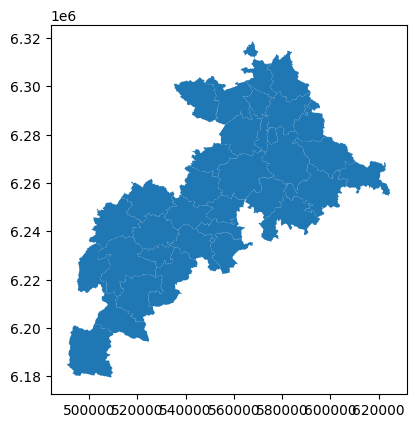

In [7]:
zones.plot()

In [8]:
zones['centroid'] = zones['geometry'].apply(lambda x : x.centroid)
# zones['area'] = zones['geometry'].apply(lambda x : x.area)

In [9]:
df_sort = df_sorties[(df_sorties["Nom du Centre"].isin(zones["secteur"])) & 
                      (df_sorties["Ordre Renfort"] == "P") & 
                      (df_sorties["Annulation de départ (O/N)"] == "non")]
df_inter = pd.merge(df_sort, df_inter, on="Numéro d'intervention", how="inner").reset_index(drop=True)

In [10]:
df_inter.columns

Index(['Numéro d'intervention', 'Ordre Renfort', 'Nom du Centre',
       'Date Heure Debut Alerte Centre', 'Date Heure Fin Sortie Centre',
       'Date Heure Acquit Presence', 'Date Heure premier départ_x',
       'Date Heure 1er sur lieux', 'Date Heure alerte 1er départ',
       'Date Heure alerte 1er sur lieux', 'Date Heure Debut Inter',
       'IU de la sortie de centre', 'Groupement Centre',
       'Annulation de départ (O/N)', 'IU de l'intervention',
       'Date Heure Début Intervention', 'Date Heure fin Intervention',
       'Date Heure premier départ_y', 'Date Heure 1er arrivée sur les lieux',
       'Date Heure Dernier Retour Personnel',
       'Date Heure Dernier Retour Engin', 'Sinistre initial - IU',
       'Sinistre initial - Nom', 'Sinistre initial - Famille',
       'Sinistre initial - Categorie', 'Localisation initiale - Coord X',
       'Localisation initiale - Coord Y'],
      dtype='object')

In [11]:
df_inter = df_inter[["Numéro d'intervention", 
       'Date Heure Début Intervention', 'Date Heure fin Intervention',
       'Sinistre initial - Nom', 'Localisation initiale - Coord X',
       'Localisation initiale - Coord Y']]

In [12]:
df_inter['coord_x'] = df_inter['Localisation initiale - Coord X'].astype(np.float32)
df_inter['coord_y'] = df_inter['Localisation initiale - Coord Y'].astype(np.float32)
df_inter = df_inter.dropna(subset=(['coord_x', 'coord_y'])).reset_index(drop=True)

frmt = '%d/%m/%Y %H:%M:%S'
df_inter['heure_debut'] = df_inter['Date Heure Début Intervention']
df_inter['heure_debut'] = pd.to_datetime(df_inter['heure_debut'], format=frmt)
s = pd.Series(df_inter['heure_debut'].values.astype(np.float32))
s[s<0] = np.NaN
df_inter['heure_debut'] = pd.to_datetime(s.interpolate())

df_inter['heure_fin'] = df_inter['Date Heure fin Intervention']
df_inter['heure_fin'] = pd.to_datetime(df_inter['heure_fin'], format=frmt)
s = pd.Series(df_inter['heure_fin'].values.astype(np.float32))
s[s<0] = np.NaN
df_inter['heure_fin'] = pd.to_datetime(s.interpolate())

df_inter["duree"] = df_inter['heure_fin'] - df_inter['heure_debut']
df_inter["duree"] = df_inter["duree"].dt.total_seconds().div(60).astype(int)
df_inter["duree"] = df_inter["duree"].apply(lambda x : x if x > 10 and x < 20*60 else df_inter["duree"].median())

df_inter["heure"] = df_inter["heure_debut"].apply(lambda x : x.hour).astype(int) 
# df_inter["jour_sem"] = df_inter["heure_debut"].apply(lambda x : x.weekday()).astype(int) 
df_inter["jour"] = df_inter["heure_debut"].dt.dayofyear - 1
df_inter["mois"] = df_inter["heure_debut"].apply(lambda x : x.month).astype(int)

# df_inter["seconde"] = df_inter["heure_debut"].apply(lambda x : (x - start_date).total_seconds()).astype(int)

v = df_inter["Sinistre initial - Nom"].value_counts()
df_inter = df_inter[df_inter["Sinistre initial - Nom"].isin(v.index[v.gt(100)])].reset_index(drop=True)
dic_sin_rank = {k:v for k, v in zip(df_inter["Sinistre initial - Nom"].value_counts().index, range(1, len(df_inter["Sinistre initial - Nom"].value_counts())+1))}
df_inter.loc[:,"sin_rank"] = df_inter["Sinistre initial - Nom"].map(dic_sin_rank).fillna(0)

gdf_real = geopandas.GeoDataFrame(df_inter, geometry=geopandas.points_from_xy(df_inter['coord_x'], df_inter['coord_y']), crs="2154")
df_inter['nom_secteur'] = gdf_real["geometry"].apply(get_secteur, args=(zones,))
df_inter['centroid'] = df_inter['nom_secteur'].apply(get_centroid, args=(zones,))

df_inter["centroid_x"] = df_inter["centroid"].apply(lambda p: p.x)
df_inter["centroid_y"] = df_inter["centroid"].apply(lambda p: p.y)
df_inter = df_inter[df_inter.centroid_x != 0]
# le = LabelEncoder()
# df_inter['secteur'] = le.fit_transform(df_inter['nom_secteur'])
# sec_density = df_inter.groupby(['secteur'])['secteur'].count().to_dict()
# df_inter["area"] = df_inter['nom_secteur'].apply(get_area, args=(zones,))
# df_inter['densite'] = df_inter["secteur"].map(sec_density)
# df_inter['densite_prop'] = df_inter['densite'] * 100000 / df_inter["area"]

# df_inter.loc[~df_inter["secteur"].isin([30,31]), "secteur"] = 0
# df_inter.loc[df_inter["secteur"].isin([30,31]), "secteur"] = 1


In [13]:
dic_rank_sin = {v:k for k, v in dic_sin_rank.items()}

In [14]:
df_rank_sin = pd.DataFrame(dic_rank_sin.items(), columns=["rank", "sin"])
df_rank_sin.to_csv("rank_sin", index=False)

In [15]:
dic_rank_sin[54]

'ZZ_U2 BLESSE AU SPORT'

In [16]:
df_inter.columns

Index(['Numéro d'intervention', 'Date Heure Début Intervention',
       'Date Heure fin Intervention', 'Sinistre initial - Nom',
       'Localisation initiale - Coord X', 'Localisation initiale - Coord Y',
       'coord_x', 'coord_y', 'heure_debut', 'heure_fin', 'duree', 'heure',
       'jour', 'mois', 'sin_rank', 'nom_secteur', 'centroid', 'centroid_x',
       'centroid_y'],
      dtype='object')

In [17]:
le = LabelEncoder()
df_inter['secteur'] = le.fit_transform(df_inter['nom_secteur'])

In [18]:
k = ['coord_x', 'coord_y', 'mois', 'jour', 'heure', 'duree', "sin_rank"]
v = ["Coord X", "Coord Y", "Month", "Day", "Hour", "Duration", "Incident"]

res = dict(map(lambda i,j : (i,j) , k,v))
res

{'coord_x': 'Coord X',
 'coord_y': 'Coord Y',
 'mois': 'Month',
 'jour': 'Day',
 'heure': 'Hour',
 'duree': 'Duration',
 'sin_rank': 'Incident'}

In [19]:
df_raw = df_inter[['coord_x', 'coord_y', 'mois', 'jour', 'heure', 'duree', "sin_rank"]].copy()
df_raw =df_raw.rename(columns=res, errors="raise")
df_raw.head()

,Coord X,Coord Y,Month,Day,Hour,Duration,Incident
0,573603.0000,6280852.0,1,0,0,54.0,4
1,558522.0000,6263928.0,1,0,0,32.0,18
2,574303.9375,6279553.0,1,0,0,25.0,7
3,571710.6875,6305442.5,1,0,0,167.0,27
4,569896.0000,6265672.0,1,0,0,41.0,1


In [20]:
df_raw.shape

(53467, 7)

In [21]:
# Sauvegarde des données
os.chdir('../Data')
df_raw.to_csv("raw_data.csv", index=False, header=True)

In [52]:
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)

In [53]:
df_sincos = df_raw.copy()
df_sincos[["mois_sin", "mois_cos"]] = df_sincos["mois"].apply(lambda x: pd.Series(encode_periodic(x, 12)))
df_sincos[["jour_sin", "jour_cos"]] = df_sincos["jour"].apply(lambda x: pd.Series(encode_periodic(x, 365)))
df_sincos[["heure_sin", "heure_cos"]] = df_sincos["heure"].apply(lambda x: pd.Series(encode_periodic(x, 24)))
df_sincos = df_sincos[['coord_x', 'coord_y', "mois_sin", "mois_cos", "jour_sin", "jour_cos", "heure_sin", "heure_cos", 'duree', 'sin_rank']]

In [54]:
df_sincos.to_csv("sin_cos.csv", index=False, header=True)

# GAN

In [ ]:
df_prep_gan = df_sincos.copy()

cols = ["coord_x", "coord_y", "duree", "sin_rank"] # , "sin_rank"

to_QT = df_prep_gan[cols].values

normalizer = sklearn.preprocessing.QuantileTransformer(
        output_distribution='normal',
        n_quantiles=max(min(to_QT.shape[0] // 30, 1000), 10),
        subsample=int(1e9),
        random_state=42)

normalizer.fit(to_QT)
QT_ed = normalizer.transform(to_QT)
df_qt[cols] = QT_ed

# CTGAN

# DDPM

# TINY

# Min Max 

In [12]:
Z['coord_x'] = feat_minmax(df_inter['coord_x'])
Z['coord_y'] = feat_minmax(df_inter['coord_y'])
# Z["area"] = feat_minmax(df_inter["area"])

# Z['centroid_x'] = feat_minmax(df_inter['centroid_x'])
# Z['centroid_y'] = feat_minmax(df_inter['centroid_y'])
# Z['densite'] = feat_minmax(df_inter['densite'])
# Z['densite_prop'] = feat_minmax(df_inter['densite_prop'])
Z['duree'] = feat_minmax(df_inter['duree'])
# df_inter['rank_std'] = feat_minmax(df_inter['sin_rank'])


In [15]:
Z

,coord_x,coord_y,mois,jour,heure,duree,sin_rank
0,0.214240,0.509197,1,0,0,-0.926684,4
1,-0.008153,0.248098,1,0,0,-0.964194,18
2,0.224577,0.489156,1,0,0,-0.976130,7
3,0.186335,0.888573,1,0,0,-0.734015,27
4,0.159575,0.275004,1,0,0,-0.948849,1
...,...,...,...,...,...,...,...
53517,0.357027,0.624134,12,364,23,-0.906223,4
53518,0.185325,0.457444,12,364,23,-0.161125,19
53519,0.150696,0.537013,12,364,23,-0.870418,4
53520,0.216846,0.445087,12,364,23,-0.167945,12


# Min Max Check

In [16]:
X_ref = df_inter[["coord_x", "coord_y", "duree"]].values.astype(np.float32)

data = Z[["coord_x", "coord_y", 'duree']].astype(np.float32)

rev_data = reverse_min_max(data, -1, 1, X_ref)

np.allclose(X_ref,rev_data)

True

In [17]:
np.array(X_ref - rev_data).mean()

-4.1237627e-07

In [18]:
np.array_equal(X_ref,rev_data)

False

In [19]:
W = Z[['coord_x', 'coord_y', 'mois', 'jour', 'heure', 'duree', "sin_rank"]].copy() # 'coord_x', 'coord_y', "centroid_x", "centroid_y",
W.head()

,coord_x,coord_y,mois,jour,heure,duree,sin_rank
0,0.214240,0.509197,1,0,0,-0.926684,4
1,-0.008153,0.248098,1,0,0,-0.964194,18
2,0.224577,0.489156,1,0,0,-0.976130,7
3,0.186335,0.888573,1,0,0,-0.734015,27
4,0.159575,0.275004,1,0,0,-0.948849,1


In [20]:
# Sauvegarde des données
os.chdir('../Data')
W.to_csv("df_prep.csv", index=False)

# Sin Cos

In [21]:
W[["mois_sin", "mois_cos"]] = W["mois"].apply(lambda x: pd.Series(encode_periodic(x, 12)))
W[["jour_sin", "jour_cos"]] = W["jour"].apply(lambda x: pd.Series(encode_periodic(x, 365)))
W[["heure_sin", "heure_cos"]] = W["heure"].apply(lambda x: pd.Series(encode_periodic(x, 24)))

# Sin Cos Check

In [22]:
W["mois_reco"] = W.apply(lambda row: decode_periodic(row['mois_sin'], row['mois_cos'], 12), axis=1)
W["jour_reco"] = W.apply(lambda row: decode_periodic(row['jour_sin'], row['jour_cos'], 365), axis=1)
W["heure_reco"] = W.apply(lambda row: decode_periodic(row['heure_sin'], row['heure_cos'], 24), axis=1)

check_mois = W["mois_reco"].equals(df_inter['mois'])
check_jour = W["jour_reco"].equals(df_inter['jour'])
check_heure = W["heure_reco"].equals(df_inter['heure'])
print(check_mois, check_jour,check_heure)

True True True


In [23]:
Y = W[['coord_x', 'coord_y', 'mois_sin', 'mois_cos', 'jour_sin', 'jour_cos', 'heure_sin', 'heure_cos', 'duree', "sin_rank"]].copy() 
# 'coord_x', 'coord_y', "centroid_x", "centroid_y",

Y.head()

,coord_x,coord_y,mois_sin,mois_cos,jour_sin,jour_cos,heure_sin,heure_cos,duree,sin_rank
0,0.214240,0.509197,0.5,0.866025,0.0,1.0,0.0,1.0,-0.926684,4
1,-0.008153,0.248098,0.5,0.866025,0.0,1.0,0.0,1.0,-0.964194,18
2,0.224577,0.489156,0.5,0.866025,0.0,1.0,0.0,1.0,-0.976130,7
3,0.186335,0.888573,0.5,0.866025,0.0,1.0,0.0,1.0,-0.734015,27
4,0.159575,0.275004,0.5,0.866025,0.0,1.0,0.0,1.0,-0.948849,1


In [24]:
# Sauvegarde des données
os.chdir('../Data')
Y.to_csv("df_prep2.csv", index=False)

In [108]:
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df_prep_tiny[["sin_rank"]])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(["sin_rank"]))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_prep_tiny = pd.concat([df_prep_tiny, one_hot_df], axis=1)

# Drop the original categorical columns
df_prep_tiny = df_prep_tiny.drop("sin_rank", axis=1)

df_prep_tiny.head()


,coord_x,coord_y,mois_sin,mois_cos,jour_sin,jour_cos,heure_sin,heure_cos,duree,sin_rank_1,...,sin_rank_49,sin_rank_50,sin_rank_51,sin_rank_52,sin_rank_53,sin_rank_54,sin_rank_55,sin_rank_56,sin_rank_57,sin_rank_58
0,0.187646,0.618059,0.5,0.866025,0.0,1.0,0.0,1.0,-0.880350,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.928040,-0.748038,0.5,0.866025,0.0,1.0,0.0,1.0,-0.915985,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.336178,0.316330,0.5,0.866025,0.0,1.0,0.0,1.0,-0.927323,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.082526,2.269421,0.5,0.866025,0.0,1.0,0.0,1.0,-0.697315,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.307930,-0.683996,0.5,0.866025,0.0,1.0,0.0,1.0,-0.901407,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
df_check = df_minmax.copy()

df_check["sin_rank"] = encoder.inverse_transform(df_prep_tiny.iloc[:, 9:])

# Stats desc

In [23]:
Z.corr()

,coord_x,coord_y,mois_sin,mois_cos,jour_sin,jour_cos,heure_sin,heure_cos,duree_std,rank_std
coord_x,1.000000,0.697514,0.013536,0.002156,0.011502,0.005421,-0.008174,0.025800,-0.094686,0.000378
coord_y,0.697514,1.000000,0.018020,0.005114,0.015736,0.009550,-0.008117,0.023240,-0.154390,-0.016108
mois_sin,0.013536,0.018020,1.000000,0.007889,0.946255,0.283917,-0.008146,-0.007404,-0.005679,-0.007856
mois_cos,0.002156,0.005114,0.007889,1.000000,-0.276693,0.949598,0.021667,-0.021874,-0.028867,-0.009335
jour_sin,0.011502,0.015736,0.946255,-0.276693,1.000000,-0.000490,-0.013759,-0.000909,0.004860,-0.004013
jour_cos,0.005421,0.009550,0.283917,0.949598,-0.000490,1.000000,0.017217,-0.023156,-0.027203,-0.010068
heure_sin,-0.008174,-0.008117,-0.008146,0.021667,-0.013759,0.017217,1.000000,-0.136068,0.015116,-0.027030
heure_cos,0.025800,0.023240,-0.007404,-0.021874,-0.000909,-0.023156,-0.136068,1.000000,-0.064894,0.013657
duree_std,-0.094686,-0.154390,-0.005679,-0.028867,0.004860,-0.027203,0.015116,-0.064894,1.000000,-0.052750
rank_std,0.000378,-0.016108,-0.007856,-0.009335,-0.004013,-0.010068,-0.027030,0.013657,-0.052750,1.000000


In [11]:
os.chdir('../Data/SIG/departement-31')

In [21]:
dep = geopandas.read_file("admin-departement.shp") 
dep_2154 = dep.to_crs(2154)
dep_2154.head()

,code_insee,nom,nuts3,wikipedia,geometry
0,31,Haute-Garonne,FR623,fr:Haute-Garonne,"POLYGON ((577524.810 6238730.771, 577904.860 6..."


In [28]:
cities = geopandas.read_file("places.shp") 
cities_2154 = cities.to_crs(2154)
cities_2154 = cities_2154[cities_2154['population'].notna()]
cities_2154.population = cities_2154.population.astype('int32')
cities_2154.head()

,osm_id,name,type,population,geometry
0,26686518,Toulouse,city,441802,POINT (574361.086 6279616.474)
1,26691412,Tournefeuille,town,26674,POINT (566430.416 6277367.888)
2,26691613,Cugnaux,town,15807,POINT (566251.056 6272281.163)
3,26691725,Blagnac,town,21710,POINT (569099.961 6284050.715)
4,26691742,Plaisance-du-Touch,town,16091,POINT (562445.090 6275508.996)


In [30]:
cities_2154_sorted = cities_2154.sort_values(by='population', ascending=False)

In [32]:
cities_2154_sorted.head(20)

,osm_id,name,type,population,geometry
0,26686518,Toulouse,city,441802,POINT (574361.086 6279616.474)
7,26692194,Colomiers,town,35186,POINT (565009.941 6280656.662)
1,26691412,Tournefeuille,town,26674,POINT (566430.416 6277367.888)
6,26692085,Muret,town,23864,POINT (564491.604 6263757.065)
3,26691725,Blagnac,town,21710,POINT (569099.961 6284050.715)
4,26691742,Plaisance-du-Touch,town,16091,POINT (562445.090 6275508.996)
2,26691613,Cugnaux,town,15807,POINT (566251.056 6272281.163)
33,26695811,Balma,town,13474,POINT (579344.907 6280271.599)
1314,1402031504,Ramonville-Saint-Agne,town,11994,POINT (576711.689 6273077.684)
8,26692504,L'Union,town,11792,POINT (577724.087 6284629.888)


In [51]:
water = geopandas.read_file("waterways.shp") 
water_2154 = water.to_crs(2154)
water_2154.head()

,osm_id,name,type,width,geometry
0,4486801,NaN,canal,NaN,"LINESTRING (573496.955 6279417.750, 573537.051..."
1,4486802,Canal du Midi,canal,NaN,"LINESTRING (572855.958 6280495.008, 572855.860..."
2,4533117,La Sausse,stream,NaN,"LINESTRING (589575.108 6281934.016, 589561.583..."
3,4545916,Canal Latéral à la Garonne,canal,NaN,"LINESTRING (572275.367 6280381.134, 572274.135..."
4,4546129,L'Hers,river,NaN,"LINESTRING (583899.990 6264633.172, 583894.555..."


In [53]:
water_2154.iloc[:20]

,osm_id,name,type,width,geometry
0,4486801,NaN,canal,NaN,"LINESTRING (573496.955 6279417.750, 573537.051..."
1,4486802,Canal du Midi,canal,NaN,"LINESTRING (572855.958 6280495.008, 572855.860..."
2,4533117,La Sausse,stream,NaN,"LINESTRING (589575.108 6281934.016, 589561.583..."
3,4545916,Canal Latéral à la Garonne,canal,NaN,"LINESTRING (572275.367 6280381.134, 572274.135..."
4,4546129,L'Hers,river,NaN,"LINESTRING (583899.990 6264633.172, 583894.555..."
5,4612199,La Garonne,river,NaN,"LINESTRING (573843.081 6274426.753, 573747.759..."
6,4612200,La Garonne,river,NaN,"LINESTRING (573833.595 6278429.996, 573931.990..."
7,4612201,La Garonne,river,NaN,"LINESTRING (573843.081 6274426.753, 573789.868..."
8,7260980,Canal de Saint-Martory,canal,NaN,"LINESTRING (553511.028 6257067.019, 553509.941..."
9,7261018,NaN,drain,NaN,"LINESTRING (566589.888 6274550.506, 566676.003..."


In [10]:
os.chdir('./SIG')

In [11]:
filename = "pdd_avant2022_iris.geojson"
# filename = "pdd_secteurs_phaseintermediaire1.geojson"
gdf_secteurs = geopandas.read_file(filename)
gdf_secteurs.head()

,iris_id_iris,iris_nom,iris_code_iris,iris_nom_code_iris,iris_insee_com,iris_nom_com,iris_commune,iris_id_deploiement,iris_nom_deploiement,iris_type_maj_pdd,...,cis19,numero_cis19,code_cis19,cis20,numero_cis20,code_cis20,cis21,numero_cis21,code_cis21,geometry
0,1,Jurvielle,312420000,Jurvielle312420000,31242,Jurvielle,NaN,278,JURVIELLE,MAJ,...,CARBONNE,15.0,C2107,Z(09)CASTILLON EN COUSERAN,127.0,NaN,RIEUX VOLVESTRE,61.0,C2455,"POLYGON ((492801.900 6197465.000, 492851.900 6..."
1,12,Caubous,311270000,Caubous311270000,31127,Caubous,NaN,138,CAUBOUS,MAJ,...,Z(09)CASTILLON EN COUSERAN,127.0,NaN,RIEUX VOLVESTRE,61.0,C2455,MURET - MASSAT,55.0,C1395,"POLYGON ((497621.600 6199626.700, 497646.200 6..."
2,138,Poulenc,315555302,Poulenc315555302,31555,Toulouse,NaN,991,TOULOUSE 139,CREATION,...,FRONTON,28.0,N1202,GRENADE,34.0,N1232,ST LYS,73.0,C1499,"POLYGON ((570811.600 6276070.500, 570804.700 6..."
3,873,Le Village,312820101,Le Village312820101,31282,Launaguet,NaN,321,LAUNAGUET 1,CREATION,...,GRENADE,34.0,N1232,VILLEFRANCHE DE LAURAGAIS,80.0,N2582,VILLEMUR S/TARN,81.0,N1584,"POLYGON ((575466.100 6287212.200, 575469.300 6..."
4,256,Lespinet S,315552301,Lespinet S315552301,31555,Toulouse,NaN,957,TOULOUSE 108,CREATION,...,CARBONNE,15.0,C2107,FRONTON,28.0,N1202,ST LYS,73.0,C1499,"POLYGON ((576386.130 6276488.500, 576404.000 6..."


In [12]:
gdf_secteurs.shape

(875, 75)

In [27]:
zones = union_iris(gdf_secteurs, "cis1" , True, ['MONTGISCARD', 'AUSSONNE', 'TOULOUSE - ATLANTA', 'TOULOUSE - CARSALADE', 'TOULOUSE - DELRIEU'])


In [28]:
zones

,secteur,geometry
0,VERFEIL,"POLYGON ((588019.690 6277285.550, 587997.860 6..."
1,RAMONVILLE - BUCHENS,"POLYGON ((574050.500 6265285.600, 574095.700 6..."
2,REVEL,"POLYGON ((610593.100 6257902.200, 610554.400 6..."
3,VILLEFRANCHE DE LAURAGAIS,"POLYGON ((596685.900 6246899.200, 596673.200 6..."
4,ROUFFIAC,"POLYGON ((574512.700 6282143.900, 574511.400 6..."
5,GRENADE,"POLYGON ((556405.100 6284119.700, 556403.700 6..."
6,ST GAUDENS,"POLYGON ((513982.000 6214719.300, 513866.200 6..."
7,VILLEMUR S/TARN,"POLYGON ((581047.800 6295803.600, 580911.900 6..."
8,LE FOUSSERET,"POLYGON ((538904.700 6242541.600, 538890.500 6..."
9,MONTREJEAU,"POLYGON ((503074.300 6216796.700, 503069.300 6..."


In [30]:
zones.loc[:,'nb_inter'] = zones["secteur"].map(d_cis_inter)

In [34]:
zones = zones.sort_values(by=['nb_inter'], ascending=False)

In [35]:
zones

,secteur,geometry,nb_inter
31,TOULOUSE - VION,"POLYGON ((570379.200 6274695.700, 570316.300 6...",10200
15,TOULOUSE - LOUGNON,"POLYGON ((574321.320 6277065.510, 574312.770 6...",9230
13,COLOMIERS,"POLYGON ((568262.100 6272154.600, 568283.100 6...",6018
1,RAMONVILLE - BUCHENS,"POLYGON ((574050.500 6265285.600, 574095.700 6...",4917
30,MURET - MASSAT,"POLYGON ((564414.300 6253054.500, 564388.900 6...",4050
4,ROUFFIAC,"POLYGON ((574512.700 6282143.900, 574511.400 6...",3618
6,ST GAUDENS,"POLYGON ((513982.000 6214719.300, 513866.200 6...",1838
14,ST JORY,"POLYGON ((569526.500 6288026.900, 569499.100 6...",1275
23,AUTERIVE,"POLYGON ((576244.900 6247876.000, 576243.200 6...",1264
5,GRENADE,"POLYGON ((556405.100 6284119.700, 556403.700 6...",1228


In [36]:
zones.to_file('zones.shp')  

In [154]:
gdf_secteurs = gdf_secteurs[~gdf_secteurs['cis1'].str.startswith('Z')]
remove_list = ["AUSSONNE", "MONTGISCARD", "TOULOUSE - ATLANTA", "TOULOUSE - CARSALADE", "TOULOUSE - DELRIEU"]
gdf_secteurs = gdf_secteurs[~gdf_secteurs['cis1'].isin(remove_list)]

In [159]:
gdf_secteurs["cis1"]

0

In [155]:
zones = gdf_secteurs.dissolve(by='cis1').reset_index()
zones = zones[["cis1", "geometry"]]
zones

,cis1,geometry
0,ASPET,"POLYGON ((518290.500 6205956.100, 518174.200 6..."
1,AURIGNAC,"POLYGON ((529702.800 6234700.900, 529593.100 6..."
2,AUTERIVE,"POLYGON ((572434.700 6246655.300, 572291.500 6..."
3,BAGNERES DE LUCHON,"POLYGON ((502669.400 6181287.600, 502669.300 6..."
4,BOULOGNE SUR GESSE,"POLYGON ((508316.600 6236172.700, 508311.300 6..."
5,CADOURS,"POLYGON ((543363.900 6287692.300, 543361.600 6..."
6,CARAMAN,"POLYGON ((599199.300 6263334.000, 599256.300 6..."
7,CARBONNE,"POLYGON ((551636.800 6244944.200, 551529.900 6..."
8,CAZERES,"POLYGON ((541559.800 6229489.000, 541515.400 6..."
9,CINTEGABELLE,"POLYGON ((578410.400 6237241.200, 578415.200 6..."


In [1]:
zones.to_csv("zones")

NameError: name 'zones' is not defined

In [129]:
zones.shape

(34, 2)

In [55]:
gdf_inter = geopandas.GeoDataFrame(
    df_inter, geometry=geopandas.points_from_xy(df_inter['Localisation initiale - Coord X'], df_inter['Localisation initiale - Coord Y']), crs="2154"
)

In [22]:
os.chdir("../")

In [23]:
csv_file = "./sorties_2018.csv"
df_sorties = pd.read_csv(csv_file, sep=";")
df_sorties.head()

,Numéro d'intervention,Ordre Renfort,Nom du Centre,Date Heure Debut Alerte Centre,Date Heure Fin Sortie Centre,Date Heure Acquit Presence,Date Heure premier départ,Date Heure 1er sur lieux,Date Heure alerte 1er départ,Date Heure alerte 1er sur lieux,Date Heure Debut Inter,IU de la sortie de centre,Groupement Centre,Annulation de départ (O/N)
0,1,P,TOULOUSE - VION,01/01/2018 12:05:21 AM,01/01/2018 01:01:47 AM,01/01/2018 12:05:43 AM,01/01/2018 12:09:51 AM,01/01/2018 12:13:07 AM,01/01/2018 12:05:21 AM,01/01/2018 12:05:21 AM,01/01/2018 12:05:21 AM,00000001-00-18-1-1,N-EST,non
1,2,P,MURET - MASSAT,01/01/2018 12:11:43 AM,01/01/2018 12:44:46 AM,01/01/2018 12:12:54 AM,01/01/2018 12:14:15 AM,NaN,01/01/2018 12:11:43 AM,NaN,01/01/2018 12:11:43 AM,00000002-00-18-1-1,N-OUEST,non
2,3,P,TOULOUSE - LOUGNON,01/01/2018 12:13:35 AM,01/01/2018 12:37:34 AM,01/01/2018 12:14:06 AM,01/01/2018 12:15:38 AM,NaN,01/01/2018 12:13:35 AM,NaN,01/01/2018 12:13:35 AM,00000003-00-18-1-1,N-EST,non
3,4,P,FRONTON,01/01/2018 12:13:46 AM,01/01/2018 03:00:34 AM,01/01/2018 12:17:28 AM,01/01/2018 12:21:32 AM,01/01/2018 12:27:50 AM,01/01/2018 12:13:46 AM,01/01/2018 12:13:46 AM,01/01/2018 12:13:46 AM,00000004-00-18-1-1,N-OUEST,non
4,5,P,MURET - MASSAT,01/01/2018 12:14:53 AM,01/01/2018 12:55:25 AM,01/01/2018 12:15:17 AM,01/01/2018 12:18:37 AM,01/01/2018 12:27:13 AM,01/01/2018 12:14:53 AM,01/01/2018 12:14:53 AM,01/01/2018 12:14:53 AM,00000005-00-18-1-1,N-OUEST,non


In [24]:
df_cis = df_sorties[df_sorties["Ordre Renfort"] == "P"]

In [25]:
d_cis_inter ={k:v for k, v in df_cis["Nom du Centre"].value_counts().items()}

In [26]:
d_cis_inter

{'TOULOUSE - VION': 10200,
 'TOULOUSE - LOUGNON': 9230,
 'COLOMIERS': 6018,
 'RAMONVILLE - BUCHENS': 4917,
 'MURET - MASSAT': 4050,
 'ROUFFIAC': 3618,
 'ST GAUDENS': 1838,
 'ST JORY': 1275,
 'AUTERIVE': 1264,
 'GRENADE': 1228,
 'ST LYS': 1121,
 'FRONTON': 997,
 'VILLEFRANCHE DE LAURAGAIS': 937,
 'REVEL': 886,
 'CARBONNE': 851,
 'CAZERES': 839,
 'VILLEMUR S/TARN': 839,
 'MONTREJEAU': 689,
 'BAGNERES DE LUCHON': 688,
 'CINTEGABELLE': 623,
 'RIEUMES': 548,
 'SALIES DU SALAT': 547,
 'CARAMAN': 490,
 'ST BEAT': 367,
 'VERFEIL': 364,
 'CADOURS': 348,
 'BOULOGNE SUR GESSE': 337,
 'MONTESQUIEU VOLVESTRE': 325,
 'RIEUX VOLVESTRE': 323,
 'LE FOUSSERET': 320,
 'ST MARTORY': 304,
 'ISLE EN DODON': 272,
 'AURIGNAC': 208,
 'ASPET': 194,
 "Z(32)L'ISLE JOURDAIN": 123,
 'Z(09)LEZAT S/LEZE': 119,
 'Z(81)ST SULPICE': 101,
 'X-PCC1': 69,
 'Z(65)LANNEMEZAN': 35,
 'X-PCC4': 18,
 'Z(81)SOREZE': 17,
 'Z(09)MAZERES': 14,
 'Z(82)GRISOLLES': 13,
 'X-GPT PREVISION': 12,
 'Z(32)COLOGNE': 11,
 'Z(82)VERDUN/GARONNE'

In [133]:
zones.loc[:,'nb_inter'] = zones["cis1"].map(d_cis_inter)

In [134]:
zones

,cis1,geometry,nb_inter
0,ASPET,"POLYGON ((518290.500 6205956.100, 518174.200 6...",194
1,AURIGNAC,"POLYGON ((529702.800 6234700.900, 529593.100 6...",208
2,AUTERIVE,"POLYGON ((572434.700 6246655.300, 572291.500 6...",1264
3,BAGNERES DE LUCHON,"POLYGON ((502669.400 6181287.600, 502669.300 6...",688
4,BOULOGNE SUR GESSE,"POLYGON ((508316.600 6236172.700, 508311.300 6...",337
5,CADOURS,"POLYGON ((543363.900 6287692.300, 543361.600 6...",348
6,CARAMAN,"POLYGON ((599199.300 6263334.000, 599256.300 6...",490
7,CARBONNE,"POLYGON ((551636.800 6244944.200, 551529.900 6...",851
8,CAZERES,"POLYGON ((541559.800 6229489.000, 541515.400 6...",839
9,CINTEGABELLE,"POLYGON ((578410.400 6237241.200, 578415.200 6...",623


In [136]:
zones['coords'] = zones['geometry'].apply(lambda x: x.representative_point().coords[:])
zones['coords'] = [coords[0] for coords in zones['coords']]

In [143]:
zones['num'] = range(1, 35)

In [187]:
secteurs_2021_original.columns

Index(['nom_secteur', 'geometry'], dtype='object')

In [188]:
secteurs_2021_original.loc[:,'nb_inter'] = secteurs_2021_original["nom_secteur"].map(d_cis_inter)

secteurs_2021_original.head()

,nom_secteur,geometry,nb_inter
0,VILLEMUR S/TARN,"POLYGON ((581047.800 6295803.600, 580911.900 6...",839
1,MONTREJEAU,"POLYGON ((503074.300 6216796.700, 503069.300 6...",689
2,MURET - MASSAT,"POLYGON ((564414.300 6253054.500, 564388.900 6...",4050
3,CINTEGABELLE,"POLYGON ((578410.400 6237241.200, 578415.200 6...",623
4,CAZERES,"POLYGON ((541559.800 6229489.000, 541515.400 6...",839


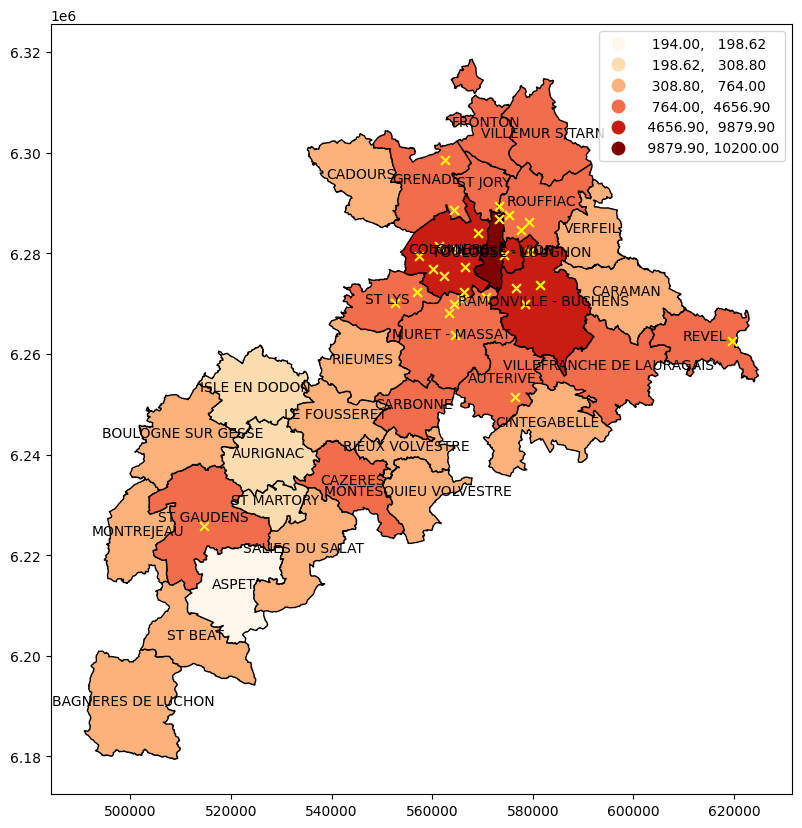

In [196]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_aspect('equal')

# dep_2154.plot(ax=ax, color='white', edgecolor='black')

# zones.plot(ax=ax, color="white", edgecolor='black')
# zones.apply(lambda x: ax.annotate(text=x['cis1'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

# gdf_secteurs.plot(ax=ax, color="white", edgecolor='black')
# gdf_secteurs.apply(lambda x: ax.annotate(text=x['nom'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

secteurs_2021_original.plot(ax=ax, column="nb_inter", cmap='OrRd', scheme='percentiles', legend=True, edgecolor='black')
secteurs_2021_original.apply(lambda x: ax.annotate(text=x['nom_secteur'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

# gdf_inter.plot(ax=ax, marker='.', color='blue', markersize=5, alpha = .05)
cities_2154_sorted.iloc[:30].plot(ax=ax, marker='x', color='yellow', markersize=40)
# water_2154.plot(ax=ax, color='blue', markersize=5, alpha = .5)



plt.show();

In [53]:
df_inter[df_inter['Sinistre initial - Nom'] == "FEU DE CHEMINEE"]["mois"].value_counts().sort_index()

1     40
2     76
3     47
4     23
5     24
6      2
7      1
9      1
10     6
11    12
12    22
Name: mois, dtype: int64

In [8]:
df_inter['Sinistre initial - Nom'].unique()

array(['U1 MALAISE DANS UN ERP',
       'AUTRES FEUX EN PLEIN AIR (SANS PRÉCISION)',
       'U1 MALAISE SUR VOIE PUBLIQUE', 'EU MALAISE GRAVE A DOMICILE',
       'U1 MALAISE A DOMICILE', 'FEU DE VEHICULE LEGER OU DEUX ROUES',
       'U1 PNRPAA AVEC SUSPICION DE DETRESSE < R+2',
       'SOUTIEN LOGISTIQUE SMUR', 'FEU DE POUBELLE EN PLEIN AIR',
       'U1 PERSONNE INCONSCIENTE A DOMICILE', 'U1 BLESSE A DOMICILE',
       'U1 PERSONNE INCONSCIENTE DANS ERP', 'U1 ACCOUCHEMENT IMMINENT',
       'ACCIDENT DE CIRCULATION', 'U1 BLESSE SUR VOIE PUBLIQUE',
       'U1 PERSONNE INCONSCIENTE SUR VOIE PUBLIQUE',
       'U2 BLESSE DANS UN ERP', 'OUVERTURE DE PORTE',
       'ZZ_U2 BLESSE A DOMICILE',
       'FEU DE COMMUNS (ESCALIER, VIDE ORDURE, CAVE, CHAUFFERIE...)',
       'ACCIDENT DE CIRCULATION AUTOROUTE',
       'U1 PNRPAA AVEC SUSPICION DE DETRESSE > R+2',
       'U2 MALAISE SUR VOIE PUBLIQUE', 'U2 MALAISE A DOMICILE',
       'U1 DECLENCHEMENT TELEASSISTANCE AVEC SUSPICION DE DETRESS',
       '

In [9]:
df_inc = df_inter[["cat_sini", "mois", 'coord_x', 'coord_y']]
df_inc = pd.get_dummies(df_inc, columns=['cat_sini'], prefix='sin', prefix_sep='_')
df_inc

KeyError: "None of [Index(['cat_sini', 'mois', 'coord_x', 'coord_y'], dtype='object')] are in the [columns]"

In [60]:
df_vehicles.columns

Index(['Numéro d'intervention', 'IU du moyen engagé', 'IU Materiel',
       'Ordre materiel', 'Type materiel', 'Fonction materiel', 'Numero Depart',
       'Mission', 'Nom du Centre', 'Ordre Defense',
       'IU Plan Dep utilisé pour ce matériel', 'Effectif Depart',
       'Effectif Theorique', 'Effectif Officier', 'Effectif Sous Officier',
       'Effectif Sapeur', 'Sous Effectif (O/N)', 'Date Heure Alerte',
       'Date Heure du départ', 'Date Heure Arrivée sur les lieux',
       'Date Heure Départ des lieux', 'Date Heure Arrivée au CH',
       'Date Heure Départ du CH', 'Date Heure Retour Centre',
       'Date Heure Dispo Engin'],
      dtype='object')

In [70]:
df_int = df_inter[["Numéro d'intervention", "mois", "jour", "heure", "duree", 'coord_x', 'coord_y']]
df_veh = df_vehicles[["Numéro d'intervention", "Type materiel", "Fonction materiel", "Numero Depart", 'Ordre Defense',
       'IU Plan Dep utilisé pour ce matériel']]

In [71]:
df_merged = pd.merge(df_int, df_veh, on="Numéro d'intervention")

In [72]:
df_merged.head(12)

,Numéro d'intervention,mois,jour,heure,duree,coord_x,coord_y,Type materiel,Fonction materiel,Numero Depart,Ordre Defense,IU Plan Dep utilisé pour ce matériel
0,1,1,0,0,56,0.203528,0.493791,VSAV,VSAV,1,2.0,631.0
1,2,1,0,0,33,-0.007746,0.251095,FPT,FPT,1,1.0,289.0
2,3,1,0,0,23,0.213347,0.475163,VSAV,VSAV,1,1.0,670.0
3,4,1,0,0,166,0.177018,0.846424,VSAV,VSAV,1,1.0,236.0
4,5,1,0,0,40,0.151596,0.276105,VSAV,VSAV,1,4.0,478.0
5,6,1,0,0,71,0.172409,0.442290,FPT,FPTL,1,1.0,696.0
6,6,1,0,0,71,0.172409,0.442290,CCF,CCF,2,1.0,696.0
7,7,1,0,0,33,0.123199,0.407864,FPT,FPTL,1,1.0,644.0
8,8,1,0,0,60,-0.382018,-0.004076,VSAV,VSAV,1,1.0,356.0
9,8,1,0,0,60,-0.382018,-0.004076,VID,VID,1,1.0,356.0


In [90]:
nb_veh = []
nb_inter = []

for h in range(0, 24):
    a = len(df_merged[df_merged["heure"] == h]["Fonction materiel"])
    nb_veh.append(a)
    b = df_merged[df_merged["heure"] == h]["Numéro d'intervention"].nunique()
    nb_inter.append(b)
    print(h, "\n", )# value_counts()[:10])
    print(a, b, a/b)

0 

2361 1762 1.3399545970488083
1 

1918 1457 1.3164035689773508
2 

1643 1239 1.3260694108151736
3 

1438 1087 1.3229070837166514
4 

1216 946 1.285412262156448
5 

1251 874 1.431350114416476
6 

1574 983 1.6012207527975586
7 

2438 1485 1.6417508417508417
8 

3380 2273 1.4870215574131105
9 

3881 2632 1.4745440729483283
10 

4232 2969 1.4253957561468509
11 

4507 3280 1.3740853658536585
12 

4468 3224 1.3858560794044665
13 

3958 2835 1.3961199294532627
14 

3987 2870 1.389198606271777
15 

4241 3052 1.3895806028833553
16 

4636 3149 1.4722134010797079
17 

4868 3338 1.458358298382265
18 

4846 3343 1.449596171103799
19 

4491 3294 1.3633879781420766
20 

4149 3094 1.3409825468648997
21 

3541 2626 1.3484386900228484
22 

2995 2240 1.3370535714285714
23 

2842 2075 1.3696385542168674


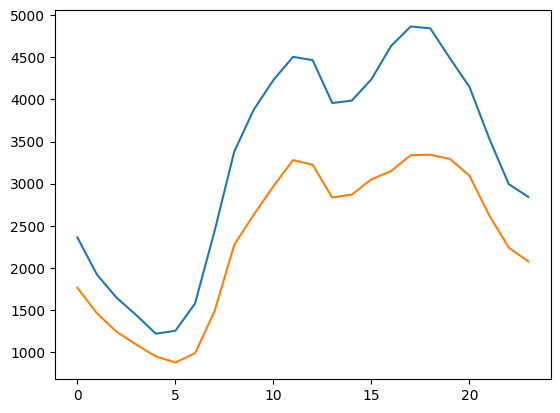

In [94]:
plt.plot(nb_veh)
plt.plot(nb_inter)

In [95]:
nb_veh = []
nb_inter = []

for j in range(0, 7):
    print(j, "\n")
    a = len(df_merged[df_merged["jour"] == j])
    nb_veh.append(a)
    b = df_merged[df_merged["jour"] == j]["Numéro d'intervention"].nunique()
    nb_inter.append(b)
    print(a, b, a/b)

0 

11494 8121 1.415342938061815
1 

10877 7581 1.4347711383722463
2 

11005 7710 1.427367055771725
3 

11236 7843 1.4326150707637384
4 

11884 8326 1.4273360557290415
5 

11514 8427 1.366322534709861
6 

10851 8119 1.336494642197315


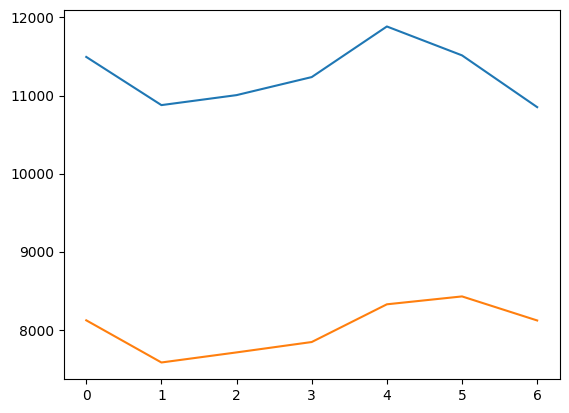

In [96]:
plt.plot(nb_veh)
plt.plot(nb_inter)

In [73]:
for m in range(1, 13):
    print(m, "\n", df_merged[df_merged["mois"] == m]["Fonction materiel"].value_counts()[:10])

1 
 VSAV          4118
VID            546
FPTL           299
VCG            270
FPT            243
EPA            166
VF             135
VID PROTEC     103
VSR PROTEC      98
VSR             95
Name: Fonction materiel, dtype: int64
2 
 VSAV          3831
VID            525
FPT            303
VCG            229
FPTL           212
EPA            140
VSR PROTEC      88
VF              85
VID PROTEC      80
VSR             69
Name: Fonction materiel, dtype: int64
3 
 VSAV          4353
VID            529
VCG            288
FPTL           270
FPT            264
EPA            169
VID PROTEC     124
VSR PROTEC     118
VSR            104
VF              79
Name: Fonction materiel, dtype: int64
4 
 VSAV          3827
VID            518
FPTL           369
FPT            285
VCG            229
EPA            152
VF             107
VID PROTEC     102
CCF             97
VSR PROTEC      91
Name: Fonction materiel, dtype: int64
5 
 VSAV          4321
VID            552
FPTL           275
VCG        

In [101]:
df_m = df_merged[["jour", "heure"]]

<AxesSubplot: >

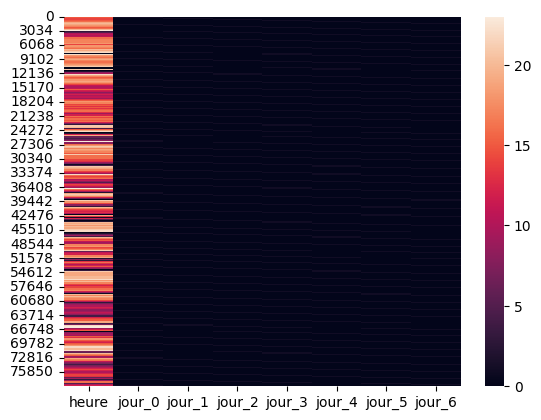

In [105]:
df_dum = pd.get_dummies(df_m, columns=["jour"])
sns.heatmap(df_dum)
# df_dum.head()

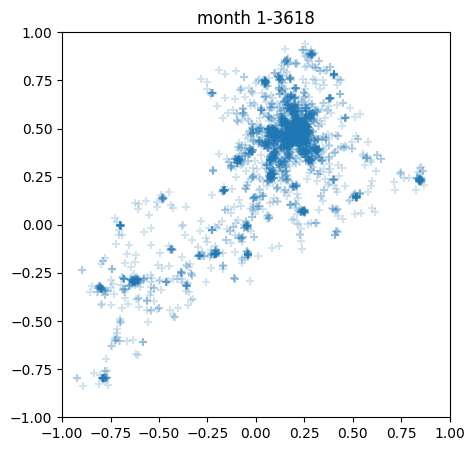

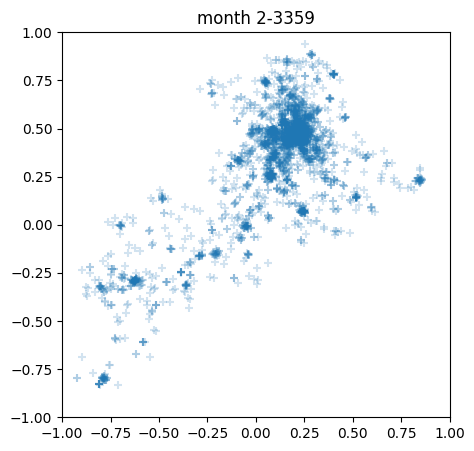

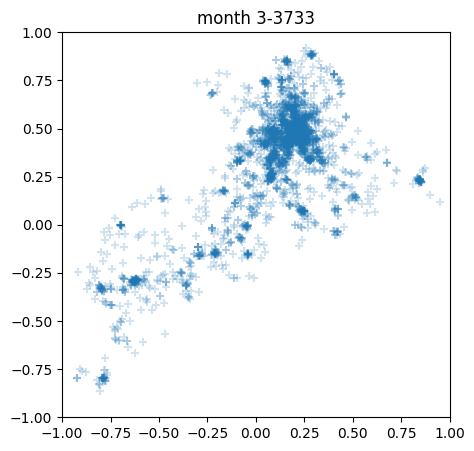

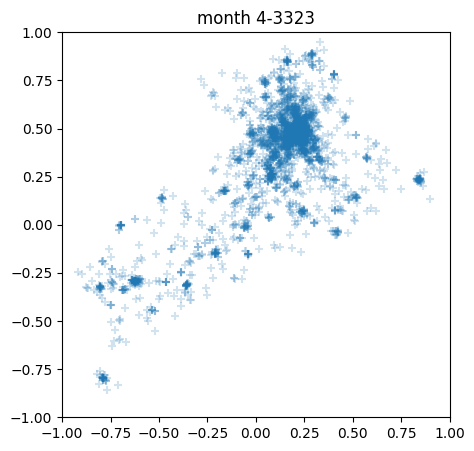

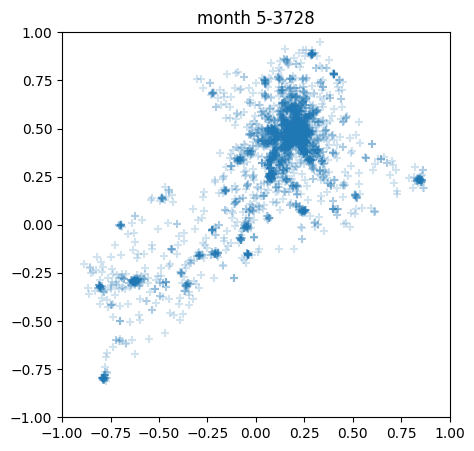

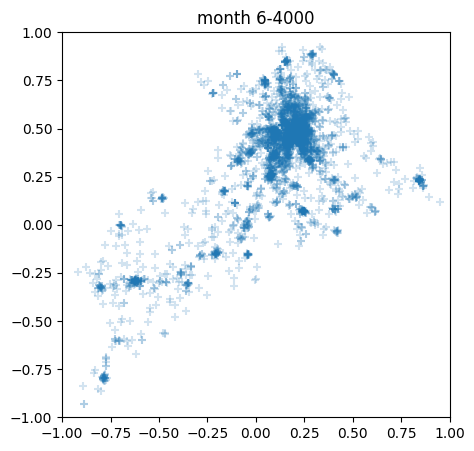

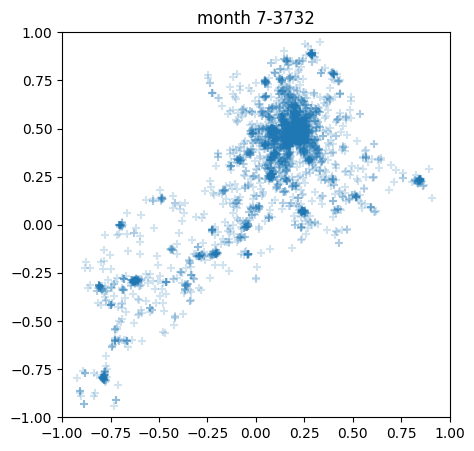

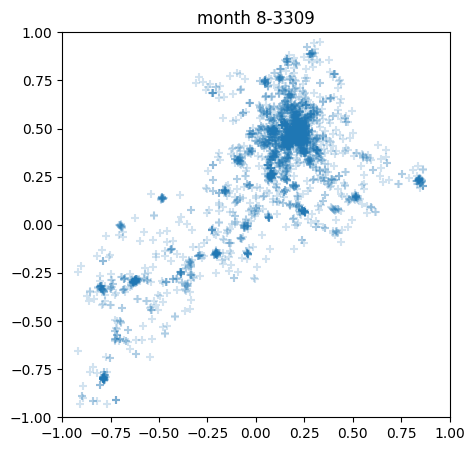

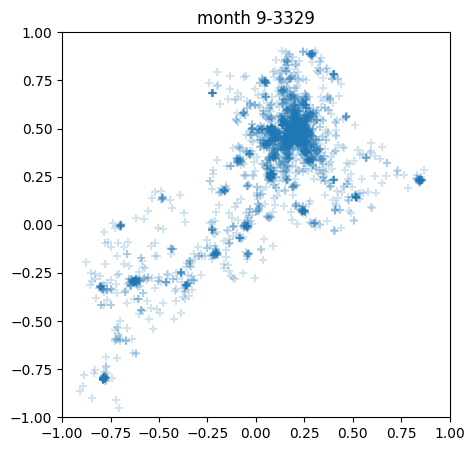

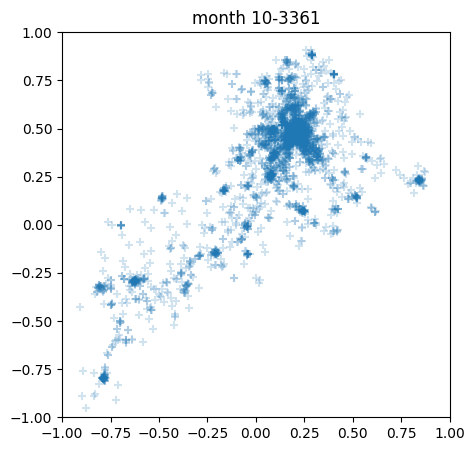

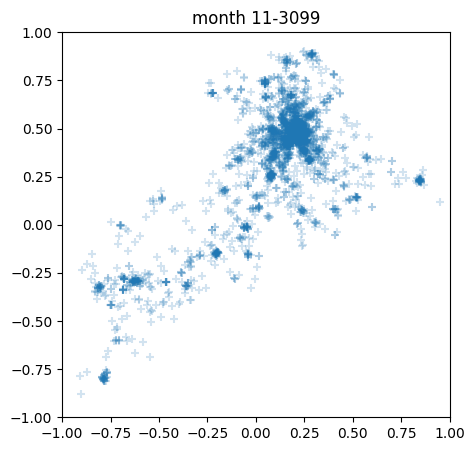

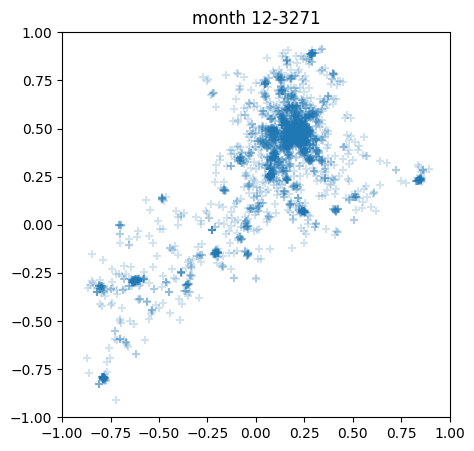

In [31]:
xmin, xmax = -1, 1
ymin, ymax = -1, 1


for m in range(1, 13):
    plt.figure(figsize=(5, 5))
    current_month = df_inc[df_inc["mois"]==m]
    plt.scatter(current_month.loc[:, "coord_x"], current_month.loc[:, "coord_y"], marker = "+", alpha = 0.2)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title("month " + str(m) + "-" + str(len(current_month)))
    plt.show()

In [13]:
os.chdir('../Data')
csv_file = "./materiel_2018.csv"
df_vehicles = pd.read_csv(csv_file, sep=";")
df_vehicles = df_vehicles.fillna("-")

/tmp/ipykernel_6981/3417320583.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicles = pd.read_csv(csv_file, sep=";")


In [14]:
df_vehicles[df_vehicles["Numero Depart"] == 1]["Fonction materiel"].value_counts()

VSAV          47552
VID            6209
FPTL           3593
FPT            3203
VCG            2509
              ...  
VL CODIS M        1
VL CODIS C        1
VL RENS PC        1
CAMPLATEAU        1
VGD               1
Name: Fonction materiel, Length: 91, dtype: int64

In [134]:
df_vehicles[df_vehicles["Numero Depart"] == 2]["Fonction materiel"].value_counts()

VSAV     1665
VCG       714
VID       366
EPA       338
VF        207
         ... 
RIMP        1
CEIN        1
CEPOL       1
CEAR        1
GRIMP       1
Name: Fonction materiel, Length: 67, dtype: int64

In [135]:
df_vehicles[df_vehicles["Numero Depart"] == 3]["Fonction materiel"].value_counts()

VCG           194
VSAV          157
VF             60
VID            48
CCF            38
FPT            36
EPA            36
VPCE           24
VSR            16
VL             16
VSR PROTEC     13
VTP            12
PCC            11
FPTL           11
VLHR            8
CCGC            7
VF4X4           7
VLTC            7
CAMERA          7
VLD             7
VID PROTEC      6
CESD            5
FPTSR           4
PT TRANSIT      4
VGRIMP          4
VPCE SD         3
FMOGP           3
EPC18           3
PSECINC         2
BLS             2
CCFS            2
CECGC           2
FPT H INC       2
VSAT            2
FPTSR PROT      2
VICH            2
VGELD           1
PSECSAP         1
COMPL           1
PSECSAP_EU      1
XCTA            1
CCI             1
ULTT            1
FPT RCH         1
CCFL2000        1
EMB             1
VTU             1
CEAEGC          1
MPR             1
CCF RECO        1
CEPOL           1
PSECSAP2        1
CDHR            1
Name: Fonction materiel, dtype: int64

In [122]:
df_v_eu_u1 = df_vehicles[df_vehicles["Numéro d'intervention"].isin(df_eu_u1["Numéro d'intervention"].values)]
df_v_eu_u1

,Numéro d'intervention,IU du moyen engagé,IU Materiel,Ordre materiel,Type materiel,Fonction materiel,Numero Depart,Mission,Nom du Centre,Ordre Defense,...,Effectif Sapeur,Sous Effectif (O/N),Date Heure Alerte,Date Heure du départ,Date Heure Arrivée sur les lieux,Date Heure Départ des lieux,Date Heure Arrivée au CH,Date Heure Départ du CH,Date Heure Retour Centre,Date Heure Dispo Engin
0,1,00000001-00-18-1-1-1-1,2202,2,VSAV,VSAV,1,-,TOULOUSE - VION,2.0,...,2.0,non,01/01/2018 12:05:21 AM,01/01/2018 12:09:51 AM,01/01/2018 12:13:07 AM,01/01/2018 12:37:38 AM,01/01/2018 12:39:00 AM,-,01/01/2018 01:00:58 AM,01/01/2018
2,3,00000003-00-18-1-1-1-1,1938,3,VSAV,VSAV,1,-,TOULOUSE - LOUGNON,1.0,...,2.0,non,01/01/2018 12:13:35 AM,01/01/2018 12:15:38 AM,-,-,-,-,01/01/2018 12:37:27 AM,-
3,4,00000004-00-18-1-1-1-1,2093,2,VSAV,VSAV,1,-,FRONTON,1.0,...,2.0,non,01/01/2018 12:13:46 AM,01/01/2018 12:21:32 AM,01/01/2018 12:27:50 AM,01/01/2018 01:23:07 AM,01/01/2018 01:59:19 AM,-,01/01/2018 02:59:49 AM,-
4,5,00000005-00-18-1-1-1-1,2378,4,VSAV,VSAV,1,-,TOULOUSE - VION,4.0,...,2.0,non,01/01/2018 12:14:53 AM,01/01/2018 12:18:37 AM,01/01/2018 12:27:13 AM,-,-,-,01/01/2018 12:55:07 AM,-
8,8,00000008-00-18-1-1-1-1,1909,1,VSAV,VSAV,1,-,LE FOUSSERET,1.0,...,2.0,non,01/01/2018 12:26:10 AM,01/01/2018 12:31:17 AM,-,-,-,-,01/01/2018 12:31:34 AM,01/01/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79943,57832,00057832-00-18-1-1-1-1,1935,1,VSAV,VSAV,1,-,ST GAUDENS,1.0,...,2.0,non,31/12/2018 11:43:52 PM,31/12/2018 11:46:38 PM,31/12/2018 11:52:27 PM,01/01/2019 12:11:29 AM,01/01/2019 12:12:28 AM,-,01/01/2019 12:41:04 AM,01/01/2019
79944,57833,00057833-00-18-1-1-1-1,1884,1,VSAV,VSAV,1,-,ASPET,1.0,...,2.0,non,31/12/2018 11:46:03 PM,31/12/2018 11:59:01 PM,01/01/2019 12:17:53 AM,01/01/2019 12:17:53 AM,01/01/2019 12:34:55 AM,-,01/01/2019 01:05:18 AM,01/01/2019
79945,57834,00057834-00-18-1-1-1-1,2095,2,VSAV,VSAV,1,-,ROUFFIAC,1.0,...,2.0,non,31/12/2018 11:46:19 PM,31/12/2018 11:49:13 PM,31/12/2018 11:54:33 PM,01/01/2019 12:17:27 AM,01/01/2019 12:31:38 AM,-,01/01/2019 12:51:35 AM,01/01/2019
79946,57836,00057836-00-18-1-1-1-1,2200,1,VSAV,VSAV,1,-,COLOMIERS,1.0,...,2.0,non,31/12/2018 11:53:31 PM,31/12/2018 11:55:15 PM,01/01/2019 12:02:01 AM,01/01/2019 12:29:35 AM,01/01/2019 12:34:24 AM,-,01/01/2019 01:13:43 AM,01/01/2019


In [126]:
df_v_eu_u1[df_v_eu_u1["Numero Depart"] == 1]["Fonction materiel"].value_counts()

VSAV          36505
VID            3487
EPA             598
PSECSAP         405
VF              392
PSECSAP2        269
VCG             222
FPTL            132
VPL              97
PSECSAP_EU       95
VF4X4            92
VSR PROTEC       67
VL               41
VLTC             39
VID PROTEC       35
VSR              34
FPT              31
VLHR             26
XCOMPL           24
VGRIMP           23
VLD              17
COMPL            13
ULTT              7
PSECINC           6
FPT H INC         5
EPC18             3
FPTSR PROT        3
VLOSS             2
CESD              2
VPCE SD           2
VTU               2
FPTSR             2
VTP               2
EPS               1
VSM               1
VSMP              1
VCYNO             1
CCF               1
VGD               1
Name: Fonction materiel, dtype: int64

In [132]:
df_v_eu_u1[df_v_eu_u1["Numero Depart"] > 5]["Fonction materiel"].value_counts()

VCG    1
Name: Fonction materiel, dtype: int64

In [49]:
df_trains_eu_u1 = df_v_eu_u1.groupby("Numéro d'intervention")["Fonction materiel"].apply(sorted).reset_index(name='Trains')
df_trains_eu_u1

,Numéro d'intervention,Trains
0,1,[VSAV]
1,3,[VSAV]
2,4,[VSAV]
3,5,[VSAV]
4,8,"[VID, VSAV]"
...,...,...
36759,57832,[VSAV]
36760,57833,[VSAV]
36761,57834,[VSAV]
36762,57836,[VSAV]


In [ ]:
vc = df_trains_eu_u1["Trains"].value_counts().index
for e in vc:
    print(e)

In [117]:
df_trains_eu_u1[df_trains_eu_u1["Trains"] == "FPT"]

,Numéro d'intervention,Trains


In [57]:
li = ["FPT", "VSAV", "VSAV", "FPTL"]
vehicle = "FP"
any([e == vehicle for e in li])

False

In [114]:
df_f3 = df_trains_eu_u1[df_trains_eu_u1["Trains"].apply(lambda x : len(x)>2)].reset_index(drop=True)
df_f3

,Numéro d'intervention,Trains
0,113,"[VID, VID, VSAV]"
1,263,"[VID, VID, VSAV]"
2,378,"[PSECSAP2, VF, VID]"
3,415,"[EPA, VID, VSAV]"
4,445,"[FPTL, VCG, VSAV]"
...,...,...
898,57298,"[FPTL, VCG, VCG, VSAV]"
899,57332,"[VID, VID, VSAV]"
900,57429,"[EPA, VID, VSAV]"
901,57780,"[FPT, PSECINC, VCG, VLD, VSAV, VSAV, XCOMPL]"


In [96]:
def check_veh(li, vehicle, exclude = False):
    is_veh = any([e == vehicle for e in li])
    if exclude:
        return not is_veh
    else:
        return is_veh
    

In [101]:
df_f1 = df_trains_eu_u1[df_trains_eu_u1["Trains"].apply(check_veh, args=("VSAV",True,))].reset_index(drop=True)
df_f1

,Numéro d'intervention,Trains
0,225,"[PSECSAP2, VF]"
1,318,"[PSECSAP2, VF]"
2,330,"[PSECSAP, VF]"
3,378,"[PSECSAP2, VF, VID]"
4,465,"[PSECSAP, VL]"
...,...,...
569,57244,"[PSECSAP2, VF]"
570,57246,"[PSECSAP, VID]"
571,57306,"[PSECSAP, VF]"
572,57493,"[PSECSAP2, VF]"


In [104]:
df_f1[df_f1["Numéro d'intervention"] == 2513]

,Numéro d'intervention,Trains
34,2513,[PSECSAP]


In [110]:
li = ["PSECSAP2", "VF", "VID"]
not any([e.startswith("PSEC") for e in li if len(li) == 2])

True

In [107]:
def check_PSEC(li, v_max = 2, exclude = False):
    is_PSEC = any([e.startswith("PSEC") for e in li if len(li) == v_max])
    if exclude : 
        return not is_PSEC
    else:
        return is_PSEC

In [112]:
df_f2 = df_f1[df_f1["Trains"].apply(check_PSEC, args=(2, False,))].reset_index(drop=True)
df_f2

,Numéro d'intervention,Trains
0,225,"[PSECSAP2, VF]"
1,318,"[PSECSAP2, VF]"
2,330,"[PSECSAP, VF]"
3,465,"[PSECSAP, VL]"
4,484,"[PSECSAP, VF]"
...,...,...
405,57244,"[PSECSAP2, VF]"
406,57246,"[PSECSAP, VID]"
407,57306,"[PSECSAP, VF]"
408,57493,"[PSECSAP2, VF]"


In [40]:
df1 = df_vehicles.groupby("Numéro d'intervention")["Fonction materiel"].apply(sorted).reset_index(name='Trains')
df1_vc = df1.Trains.value_counts()
tr = list(tuple(t) for t in df1_vc.index)

In [45]:
df1

,Numéro d'intervention,Trains
0,1,[VSAV]
1,2,[FPT]
2,3,[VSAV]
3,4,[VSAV]
4,5,[VSAV]
...,...,...
56847,57832,[VSAV]
56848,57833,[VSAV]
56849,57834,[VSAV]
56850,57836,[VSAV]


In [44]:
df_vehicles.groupby("Numéro d'intervention")["Fonction materiel" == 'FPTL']

KeyError: 'Column not found: False'

In [23]:


df1 = df_vehicles.groupby("Numéro d'intervention")["Fonction materiel"].apply(sorted).reset_index(name='Trains')
df1_vc = df1.Trains.value_counts()
tr = list(tuple(t) for t in df1_vc.index)
# dic_tr_sin = {k:v for k, v in zip(tr, range(len(df1_vc)))}
# df1['num_sini'] = df1['Trains'].apply(lambda x : dic_tr_sin[tuple(x)])

# dic_int_sin = {k:v for k, v in zip(df1["Numéro d'intervention"], df1["num_sini"])}

# random.seed(42)
# population = range(len(df1_vc))
# weights = df1_vc.values/sum(df1_vc)
# random.choices(population, weights=weights, k=1)

# df_inter["num_sin"] = df_inter["Numéro d'intervention"].map(dic_int_sin).fillna(random.choices(population, weights=weights, k=1)[0])
# df_inter[df_inter["Numéro d'intervention"] == 57837].values

/tmp/ipykernel_50608/3024923019.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicles = pd.read_csv(csv_file, sep=";")


In [ ]:
tr

In [9]:
# Configuration

dict_file = {'network' : 'WGAN',
             'batch_size' : 4096,
             'latent_dim' : 64,
             'hidden_dim' : 1024,
             'lr' : 0.001,
             'lr_ratio' : 0.1,
             'lr_step' : 40000,
             'num_steps' : 200000,
             'fake_label' : -1,
             'save_picture' : 1,
             'save_model' : 1,
             'save_name' : 'kr100',
             'name' : 'KR100',
             'criterion' : "KR",
             'alpha' : 0,
             'min_margin' : 0.1,
             'beta1' : 0.1,
             'beta2' : 0.999
            }

filename = 'config'

with open(r'./' + filename + '.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)

In [10]:
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [11]:
config['network']

'WGAN'